<a href="https://colab.research.google.com/github/hpink97/ML_notebooks/blob/main/fake_faces_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI generate human faces using Generative Adversarial Networks (GANs)

GANs work by training 2 models simoultaneously **(generator & discriminator)** - which are trying to fool each other... 

Generator acts as the artist. It takes in completley random inputs and attempts to general believable looking images. The discrimiator is a standard image classification model which attempts to tell real images from fake. 

In training the generator will become better at producing believable images, and the discrimator will become better at detecting the fake images, until an equilibrium is reached.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

#file manipulation
import os
import zipfile

## Import CelebA dataset - images of celebrities faces

In [2]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2023-02-13 10:18:28--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  39.5MB/s    in 36s     

2023-02-13 10:19:04 (38.2 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
##unzip
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


Found 202599 files belonging to 1 classes.


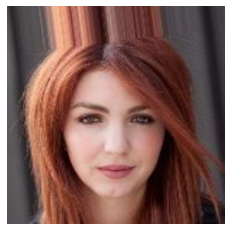

In [13]:
##import datset using keras
faces = keras.utils.image_dataset_from_directory(
    root,
    ##don't care about original labels - for our GAN they'll all be labelled REAL
    label_mode = None, 
    ##resize image to 64*64 - limited GPU!!
    batch_size = 32, 
    smart_resize = True 
)

##show sample face
for batch in faces:
  face = batch.numpy().astype('int32')[12]
  plt.axis('off')
  plt.imshow(face)
  break


In [14]:
##scale values to 0-1
faces=faces.map(lambda x:x/255.) #scale between 0-1


## GAN Discriminator - classify real vs fake images

Striding seems to work better in GANs than MaxPooling. Also using LeakyReLU seems to also work better...

In [16]:
discriminator = keras.Sequential(
    [
    keras.Input(shape=(64,64,3)), #input an image
    layers.Conv2D(filters =64, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters =128, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters =128, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
    ],
    name = 'discriminator',
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## GAN Generator 

This model will accept a random nornally distributed vector (**latent space**) as input, and generate a 64x64x3 image as output. Image will be noise to start with, but after training of model weights image should resemble a human face. 

**`Conv2DTranspose `** layers will be used to perform **deconvolution** (opposite on convolution), to generate the images. 

Kernel size of `Conv2dTransponse` layers **MUST** be divisible by stride size to avoid checkboard artifacts (linked to unequal coverage of pixel space by generator) 

`strides = 2` causes Output height x width to half in each `Conv2D layer` and dounle in each `Conv2DTransponse` layer. Important as generator model needs to reverse the dimensions of the discriminator (in order to end up with a 64x64x3 image)

In [17]:
latent_space_dim = 128 

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_space_dim,)),
    ##should be same dimension of discriminators flattened layer (8192)
        layers.Dense(8*8*128), 
     ##reverse flattening - get back to output shape from last Conv2D layer
        layers.Reshape((8,8,128)),
     ##start deconvolution 
        layers.Conv2DTranspose(128, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2D(filters = 3, ##reverts back to 3 channel image
                      kernel_size = 5, 
                      padding = 'same',
                      activation = 'sigmoid'),
     ], name = 'generator'
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## Adversiral Network - combine discriminator and generator in a model

In [ ]:
##devlop GAN class inheriting from keras model
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_space_dim):
    super().__init__()
    #add the two models
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_space_dim
    ##define loss metrics for discriminator and generator
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = keras.metrics.Mean(name= 'g_loss')
  
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer, 
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    m = [self.d_loss_metric, self.g_loss_metric]
    return m

  def train_step(self, real_img):
    batch_size = tf.shape(real_img)[0]
    latent_vector = 